In [51]:
import pandas as pd
# from soc.bert.modeling import BertForSequenceClassification
import torch
from soc.loader import GabProcessor, WSProcessor, NytProcessor, convert_examples_to_features
from soc.bert.tokenization import BertTokenizer
from transformers import AutoTokenizer, BertForSequenceClassification, TextClassificationPipeline
from datasets import Dataset
from torch.utils.data import DataLoader
import ear
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
from tqdm import tqdm
from scipy.stats import ttest_ind

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)
data.head()

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].


### Run prediction on hate check data

In [52]:
# vanilla

for seed in range(10):
    
    data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

    model_dir = f'./soc/runs/majority_gab_es_vanilla_bal_seed_{seed}/'
    model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
    results = pipe(data['test_case'].to_list())
    data['prob_non_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_0']
    data['prob_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_1']
    data['pred_label'] = [0 if a > b else 1 for (a, b) in zip(data['prob_non_hate'].to_list(), data['prob_hate'].to_list())]
    data['true_label'] = [0 if x == 'non-hateful' else 1 for x in data['label_gold']]
    os.makedirs(os.path.join(model_dir, 'prediction'), exist_ok=True)
    data.to_csv(os.path.join(model_dir, 'prediction/hatecheck.csv'), index=False)

In [54]:
# soc regularisation
for seed in tqdm(range(10), total=10):
    
    data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

    model_dir = f'./soc/runs/majority_gab_es_reg_nb5_h5_is_bal_pos_seed_{seed}/'
    model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
    results = pipe(data['test_case'].to_list())
    data['prob_non_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_0']
    data['prob_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_1']
    data['pred_label'] = [0 if a > b else 1 for (a, b) in zip(data['prob_non_hate'].to_list(), data['prob_hate'].to_list())]
    data['true_label'] = [0 if x == 'non-hateful' else 1 for x in data['label_gold']]
    os.makedirs(os.path.join(model_dir, 'prediction'), exist_ok=True)
    data.to_csv(os.path.join(model_dir, 'prediction/hatecheck.csv'), index=False)

100%|██████████| 10/10 [06:46<00:00, 40.62s/it]


In [55]:
# ear regularisation
for seed in tqdm(range(10), total=10):
    
    data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

    model_dir = f'./ear_bert/entropybert-gab25k-{seed}-0.01'
    model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, do_lower_case=True)
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
    results = pipe(data['test_case'].to_list())
    data['prob_non_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_0']
    data['prob_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_1']
    data['pred_label'] = [0 if a > b else 1 for (a, b) in zip(data['prob_non_hate'].to_list(), data['prob_hate'].to_list())]
    data['true_label'] = [0 if x == 'non-hateful' else 1 for x in data['label_gold']]
    os.makedirs(os.path.join(model_dir, 'prediction'), exist_ok=True)
    data.to_csv(os.path.join(model_dir, 'prediction/hatecheck.csv'), index=False)

100%|██████████| 10/10 [04:29<00:00, 26.99s/it]


In [57]:
# data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

model_dir = f'./soc/runs/majority_gab_es_vanilla_bal_seed_0/'
model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
# results = pipe(data['test_case'].to_list())

In [77]:
pipe(['Women are the absolute worst.'])

[[{'label': 'LABEL_1', 'score': 0.9325615763664246},
  {'label': 'LABEL_0', 'score': 0.06743844598531723}]]

<Axes: xlabel='target_ident', ylabel='count'>

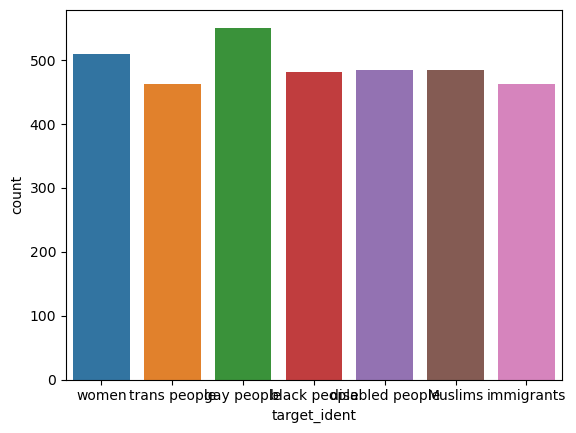

In [30]:
sns.countplot(data=data, x='target_ident')

In [60]:
funcionalities = np.unique(data['target_ident'])
results = {}
for f in funcionalities:
    f_dict = {}
    y_true = data[data['functionality']==f]['true_label'].to_list()
    y_pred = data[data['functionality']==f]['pred_label'].to_list()
    if len(y_true)==0:
        print(f)
    f_dict['accuracy'] = accuracy_score(y_true, y_pred)
    # f_dict['f1'] = f1_score(y_true, y_pred)
    # f_dict['precision'] = precision_score(y_true, y_pred)
    # f_dict['recall'] = recall_score(y_true, y_pred)
    results[f] = f_dict

In [61]:
results

{'counter_quote_nh': {'accuracy': 0.7167630057803468},
 'counter_ref_nh': {'accuracy': 0.6808510638297872},
 'derog_dehum_h': {'accuracy': 0.9357142857142857},
 'derog_impl_h': {'accuracy': 0.6357142857142857},
 'derog_neg_attrib_h': {'accuracy': 0.9071428571428571},
 'derog_neg_emote_h': {'accuracy': 0.7785714285714286},
 'ident_neutral_nh': {'accuracy': 0.2222222222222222},
 'ident_pos_nh': {'accuracy': 0.43915343915343913},
 'negate_neg_nh': {'accuracy': 0.7744360902255639},
 'negate_pos_h': {'accuracy': 0.8},
 'phrase_opinion_h': {'accuracy': 0.8571428571428571},
 'phrase_question_h': {'accuracy': 0.6857142857142857},
 'profanity_h': {'accuracy': 0.8928571428571429},
 'profanity_nh': {'accuracy': 0.0},
 'ref_subs_clause_h': {'accuracy': 0.8071428571428572},
 'ref_subs_sent_h': {'accuracy': 0.8721804511278195},
 'slur_h': {'accuracy': 0.5416666666666666},
 'slur_homonym_nh': {'accuracy': 0.3333333333333333},
 'slur_reclaimed_nh': {'accuracy': 0.7530864197530864},
 'spell_char_del_h'

## get overall performance metrics

In [72]:
acc_all = []
f1_all = []
precision_all = []
recall_all = []

In [124]:
acc = []
f1 = []
precision = []
recall = []
for seed in range(10):
    
    path = f'./soc/runs/majority_gab_es_vanilla_bal_seed_{seed}/prediction/hatecheck.csv'
    
    # path = f'./soc/runs/majority_gab_es_reg_nb5_h5_is_bal_pos_seed_{seed}/prediction/hatecheck.csv'
    # path = f'./ear_bert/entropybert-gab25k-{seed}-0.01/prediction/hatecheck.csv'
    data = pd.read_csv(path)
    # data = filter_data(data)
    pred = data['pred_label'].to_list()
    label = data['true_label'].to_list()
    acc.append(accuracy_score(y_true=label, y_pred=pred))
    f1.append(f1_score(y_true=label, y_pred=pred))
    precision.append(precision_score(y_true=label, y_pred=pred))
    recall.append(recall_score(y_true=label, y_pred=pred))
acc_all.append(acc)
f1_all.append(f1)
precision_all.append(precision)
recall_all.append(recall)
    

In [50]:
metric = [100*x for x in precision]
print(np.mean(metric))
print(np.std(metric))

76.12625758757513
0.4625614412232735


In [125]:
def filter_data(data):
    # data['true_label'] = [0 if x == 'non-hateful' else 1 for x in data['label_gold']]
    return data

In [120]:
ttest_ind(precision_all[1], precision_all[2])

Ttest_indResult(statistic=3.553053779545898, pvalue=0.0022724630690889058)

### get functionality breakdown

In [181]:
list_of_iden = list(set(data.dropna()['functionality'].to_list()))

In [191]:

funcionalities = list_of_iden
# out_list_of_dicts = []
results = {}
for f in funcionalities:
    out_dict = {}
    out_dict['split'] = f
    
    out_dict['model'] = 'EAR'
    
    f_dict = {}
    f_dict['acc'] =[]
    # f_dict['f1'] =[]
    # f_dict['precision'] =[]
    # f_dict['recall'] =[]
    for seed in range(10):
    
        # path = f'./soc/runs/majority_gab_es_vanilla_bal_seed_{seed}/prediction/hatecheck.csv'
        
        # path = f'./soc/runs/majority_gab_es_reg_nb5_h5_is_bal_pos_seed_{seed}/prediction/hatecheck.csv'
        path = f'./ear_bert/entropybert-gab25k-{seed}-0.01/prediction/hatecheck.csv'
        data = pd.read_csv(path)
        data = data.fillna('na')
        # data = filter_data(data)
        y_true = data[data['functionality']==f]['true_label'].to_list()
        y_pred = data[data['functionality']==f]['pred_label'].to_list()

        f_dict['acc'].append(accuracy_score(y_true, y_pred))
        # f_dict['f1'].append(f1_score(y_true, y_pred))
        # f_dict['precision'].append(precision_score(y_true, y_pred))
        # f_dict['recall'].append(recall_score(y_true, y_pred))
    results[f] = f_dict
    # print(results)
    out_dict['acc_mean'] = np.mean(f_dict['acc'])
    out_dict['acc_std'] = np.std(f_dict['acc'])
    # out_dict['f1_mean'] = np.mean(f_dict['f1'])
    # out_dict['f1_std'] = np.std(f_dict['f1'])
    # out_dict['precision_mean'] = np.mean(f_dict['precision'])
    # out_dict['precision_std'] = np.std(f_dict['precision'])
    # out_dict['recall_mean'] = np.mean(f_dict['recall'])
    # out_dict['recall_std'] = np.std(f_dict['recall'])
    out_list_of_dicts.append(out_dict)
    
overall_results = {}
for k, v in results.items():
    overall_results[k] = {}
    for metric, vv in v.items():
        overall_results[k][metric] = (np.mean(vv), np.std(vv))

In [192]:
results = pd.DataFrame(out_list_of_dicts)
results.to_csv('overall_results_functionality.csv', index=False)

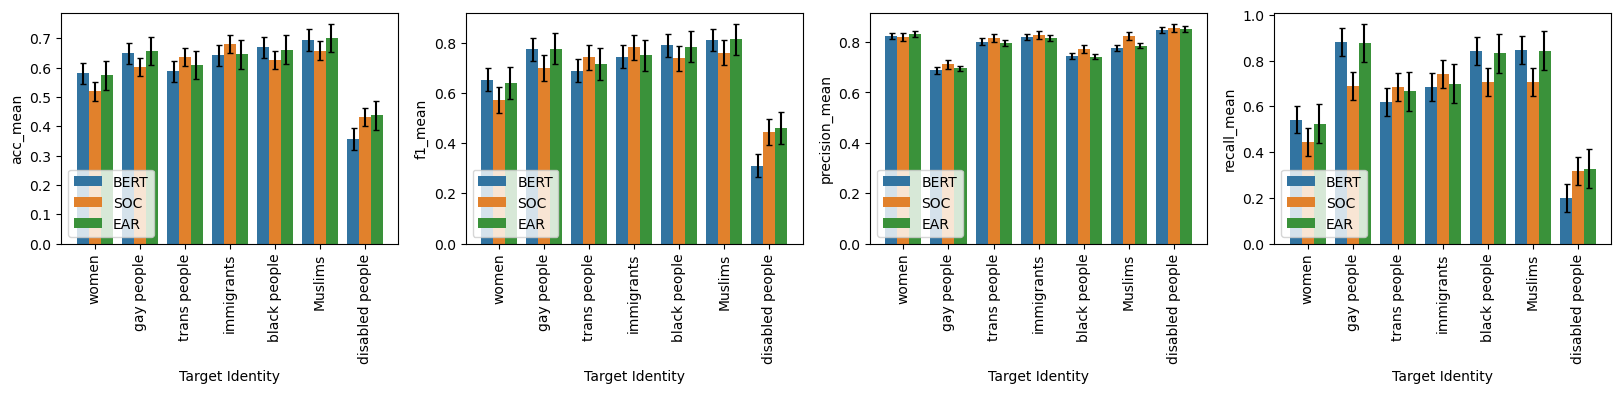

In [258]:
plt.figure(figsize=(20, 3))
results = pd.read_csv('./overall_results_target_iden.csv')
# results = results.sort_values(['model','acc_mean'],ascending=False).groupby('model')
# order = results[results['model']=='BERT'].sort_values(by='acc_mean', ascending=False)['split']
for i, y in enumerate(['acc_mean', 'f1_mean', 'precision_mean', 'recall_mean']):
    plt.subplot(1, 4, i+1)
    sns.barplot(data=results, x='split', y=y, hue='model')
    plt.xticks(rotation=90)
    plt.xlabel('Target Identity')
    plt.legend(loc=3)
    conc2 = []
    add = []
    for j in range(len(np.unique(results['split']))):
        conc2 += [j, j, j]
        width = .25
        add += [-1*width, 0 , width]
    x = np.array(conc2)+np.array(add)

    categories = results[results['model']=='BERT']['split']
    y_errs = []
    ys = []
    std_key = y.split('_',1)[0]+'_std'
    for j, cat in enumerate(categories):
        y_errs.append(results[results['model']=='BERT'][std_key].to_list()[0])
        ys.append(results[results['model']=='BERT'][y].to_list()[j])
        y_errs.append(results[results['model']=='SOC'][std_key].to_list()[0])
        ys.append(results[results['model']=='SOC'][y].to_list()[j])
        y_errs.append(results[results['model']=='EAR'][std_key].to_list()[0])
        ys.append(results[results['model']=='EAR'][y].to_list()[j])
    plt.errorbar(x = x, y = ys,
                yerr=y_errs, fmt='none', c= 'black', capsize = 2)
 
    # map(plt.errorbar, 'split', y, y.split('_',1)[0]+'_std', fmt='o', elinewidth=1, capsize=5, capthick=1)

87


<ErrorbarContainer object of 3 artists>

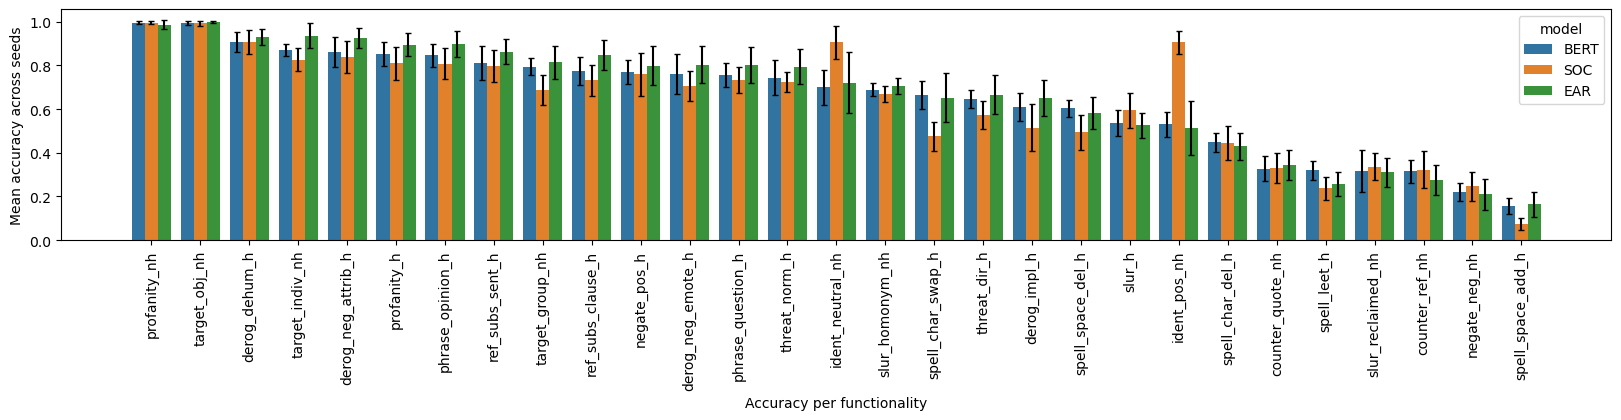

In [269]:
results = pd.read_csv('./overall_results_functionality.csv')
order = results[results['model']=='BERT'].sort_values(by='acc_mean', ascending=False)['split']
plt.figure(figsize=(20, 3))
sns.barplot(data=results, x='split', y='acc_mean', hue='model', order=order)
plt.xticks(rotation=90)
plt.xlabel('Accuracy per functionality')
plt.ylabel('Mean accuracy across seeds')
conc2 = []
add = []
for j in range(len(np.unique(results['split']))):
    conc2 += [j, j, j]
    width = .25
    add += [-1*width, 0 , width]
x = np.array(conc2)+np.array(add)

# categories = results[results['model']=='BERT']['split']
y_errs = []
ys = []
std_key = 'acc_std'
for j, cat in enumerate(order):
    y_errs.append(results[(results['model']=='BERT')&(results['split']==cat)][std_key].to_list()[0])
    ys.append(results[(results['model']=='BERT')&(results['split']==cat)]['acc_mean'].to_list()[0])
    y_errs.append(results[(results['model']=='SOC')&(results['split']==cat)][std_key].to_list()[0])
    ys.append(results[(results['model']=='SOC')&(results['split']==cat)]['acc_mean'].to_list()[0])
    y_errs.append(results[(results['model']=='EAR')&(results['split']==cat)][std_key].to_list()[0])
    ys.append(results[(results['model']=='EAR')&(results['split']==cat)]['acc_mean'].to_list()[0])
print(len(x))
plt.errorbar(x = x, y = ys,
                yerr=y_errs, fmt='none', c= 'black', capsize = 2)
 
# plt.legend(loc=3)


In [261]:
results[results['model']=='BERT'].sort_values(by='acc_mean', ascending=False)['split']

1           profanity_nh
8          target_obj_nh
21         derog_dehum_h
11       target_indiv_nh
22    derog_neg_attrib_h
10           profanity_h
16      phrase_opinion_h
2        ref_subs_sent_h
0        target_group_nh
3      ref_subs_clause_h
19          negate_pos_h
24     derog_neg_emote_h
5      phrase_question_h
27         threat_norm_h
23      ident_neutral_nh
13       slur_homonym_nh
9      spell_char_swap_h
15          threat_dir_h
25          derog_impl_h
6      spell_space_del_h
7                 slur_h
26          ident_pos_nh
20      spell_char_del_h
12      counter_quote_nh
14          spell_leet_h
18     slur_reclaimed_nh
28        counter_ref_nh
4          negate_neg_nh
17     spell_space_add_h
Name: split, dtype: object